### **Load Data**

In [1]:
import pandas as pd

# Function to load data from csv file.
def load_data(df):
    return pd.read_csv(file_path)

file_path = '../data/flight_df.csv'

# Load the dataset
df = load_data(file_path)
df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,3,2,0,0,0,1,1,0
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,4,18,2,0,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,4,5,3,0,0,1,1,0,0
3,54,3,453,3,5,5,5,3,4,4,...,3,4,3,1,91,80,0,1,1,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,3,4,0,0,1,1,1,0


### **Model Validation**

In [2]:
from sklearn.model_selection import train_test_split

# Define target and features
y = df['satisfied']
X = df.drop(columns='satisfied')

# Split the data into train and test 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [3]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Preprocessing pipeline
def create_preprocessing_pipeline():
    
    # Select numeric and categorical columns
    num_cols = make_column_selector(dtype_include='number')
    cat_cols = make_column_selector(dtype_include='object')
    
    # Instantiate the transformers
    scaler = StandardScaler()
    encoder = OneHotEncoder()
    knn_imputer = KNNImputer(n_neighbors=2, weights='uniform')
    
    # Create pipeline
    num_pipe = Pipeline([
        ('scaler', scaler),
        ('imputer', knn_imputer)
    ])
     
    cat_pipe = Pipeline([
        ('encoder', encoder)
    ])
    
    preprocessor = ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols),
    ], remainder='drop')
    
    return preprocessor

# Create preprocessor object

preprocessor = create_preprocessing_pipeline()

In [4]:
# conda install conda-forge::imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create sampler pipeline
def sampler_pipeline(sampler):
    return ImbPipeline([
        ('sampler', sampler)
    ])
    
# Preprocess and rebalance the data
def preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train):
    
    # Transform training data to the fitted transformer
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Create sampling pipeline
    sampler = sampler_pipeline(SMOTE(random_state=42))
    
    # Rebalance the data
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_transformed, y_train)
    
    return X_train_balanced, X_test_transformed, y_train_balanced

# Preprocess and rebalance the data
X_train_balanced, X_test_transformed, y_train_balanced = preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train)

In [5]:
# Convert preprocessed data back to a dataframe
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

### **Machine Learning**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # Create predictions on the training set
    train_preds = np.rint(model.predict(X_train)) # .rint = Round to the nearest INTeger
    test_preds = np.rint(model.predict(X_test))
    
    # Classification report
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)
    
    # Confusion matrix
    cm_train = confusion_matrix(y_train, train_preds)
    cm_test = confusion_matrix(y_test, test_preds)
    
    # Format figures in dark mode
    plt.style.use('dark_background')
    
    # Plot confusion matrix side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # First axis
    axes[0].text(0.01, 0.05, str(train_report), fontproperties='monospace')
    axes[0].axis('off')
    
    # Second axis
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='YlGn_r')
    axes[1].set_title('Confusion Matrix - Training Set')
    
    # Plot confusion matrix side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # First axis
    axes[0].text(0.01, 0.05, str(train_report), fontproperties='monospace')
    axes[0].axis('off')
    
    # Second axis
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Confusion Matrix - Testing Set')
    
    plt.show()
    
    return train_report, test_report
    
# from matplotlib import colormaps
# list(colormaps)

In [7]:
from sklearn.pipeline import Pipeline

# ML pipeline
def train_and_predict_model(X_train, y_train, X_test, preprocessor, model):
    
    # Combine pipeline and model
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit pipeline on training data
    model_pipe.fit(X_train, y_train)
    
    # Save predictions
    train_preds = model_pipe.predict(X_train)
    test_preds = model_pipe.predict(X_test)
    
    return train_preds, test_preds

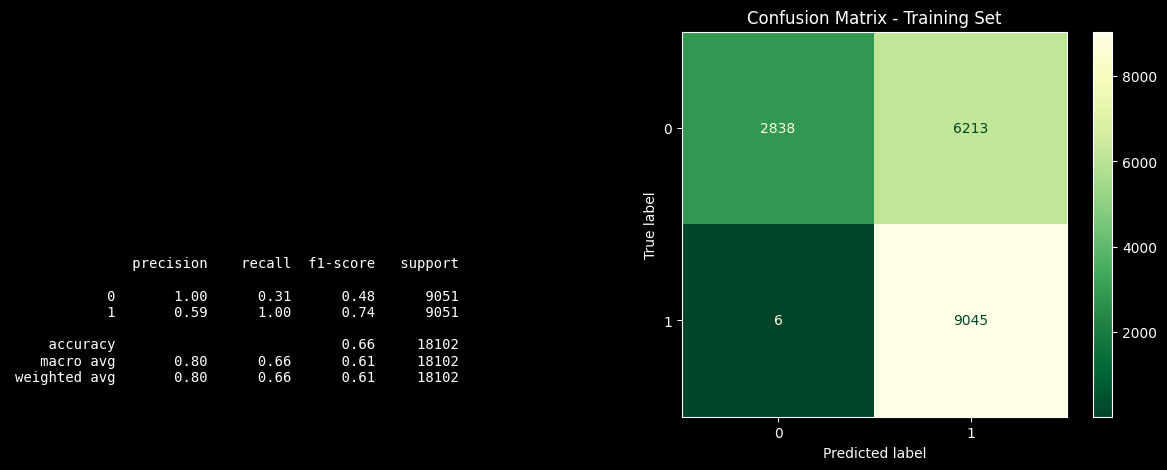

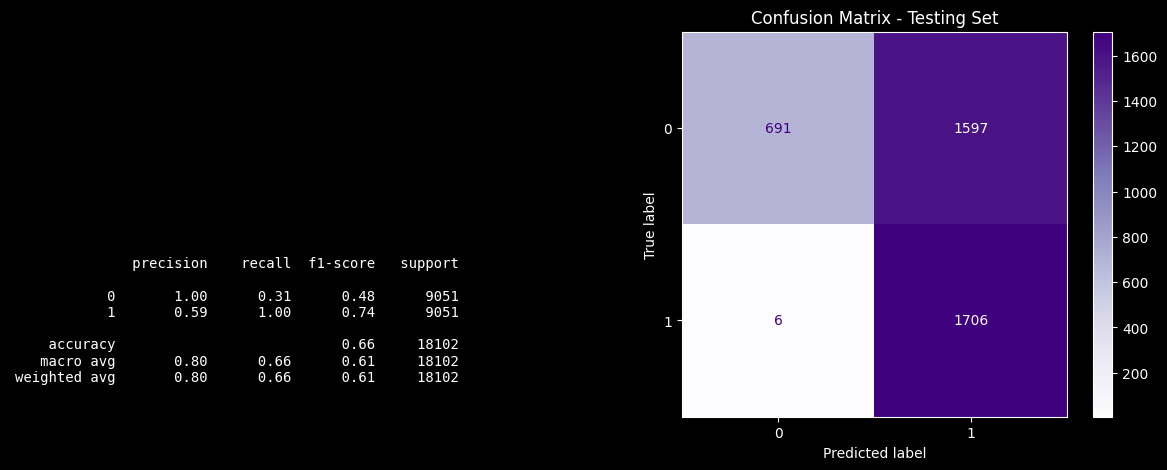

In [8]:
import lightgbm as lgb

# Instantitate the model
lgb_model = lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create and save predictions
train_preds, test_preds = train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, lgb_model)

# Return train and test reports
train_report, test_report = evaluate_model(lgb_model, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

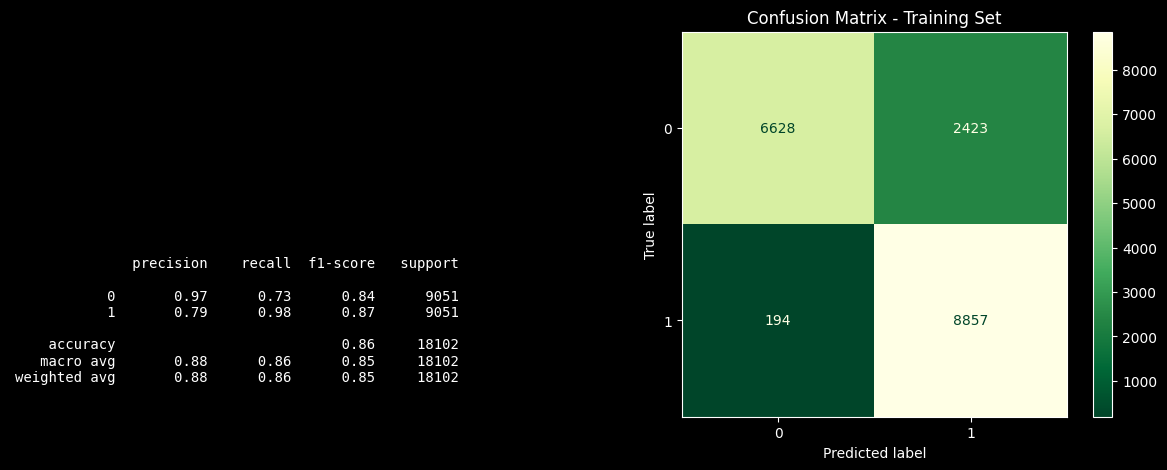

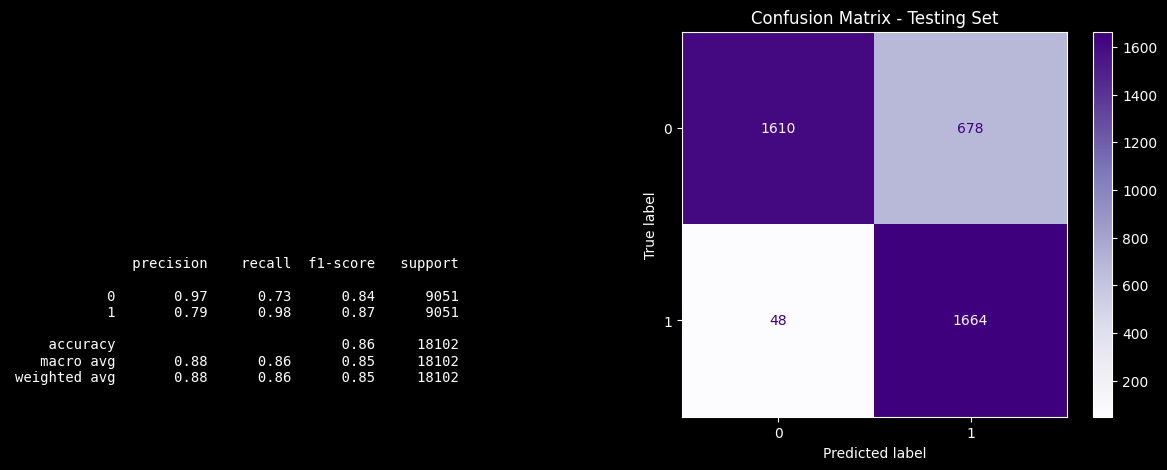

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Instantitate the model
dec_tree = DecisionTreeClassifier()

# Create and save predictions
train_preds, test_preds = train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, dec_tree)

# Return train and test reports
train_report, test_report = evaluate_model(dec_tree, X_train_balanced_df, y_train_balanced, X_test_transformed_df, y_test)

### **Model Evaluation**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    
    return model

# Get feature importance
def get_feature_importance(model):
    
    feature_names = X_train.columns
    importance = model.feature_importances_
        
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)
    
    return feature_importance

# Plot feature importance
def plot_feature_importance(feature_importance, title):
    
    plt.figure(figsize=(10, 6))
    
    # Barplot
    sns.barplot(
        data=feature_importance,
        x='importance',
        y='feature',
        palette='Spectral_r',
        hue='feature'
    )
    
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [11]:
# from matplotlib import colormaps
# list(colormaps)

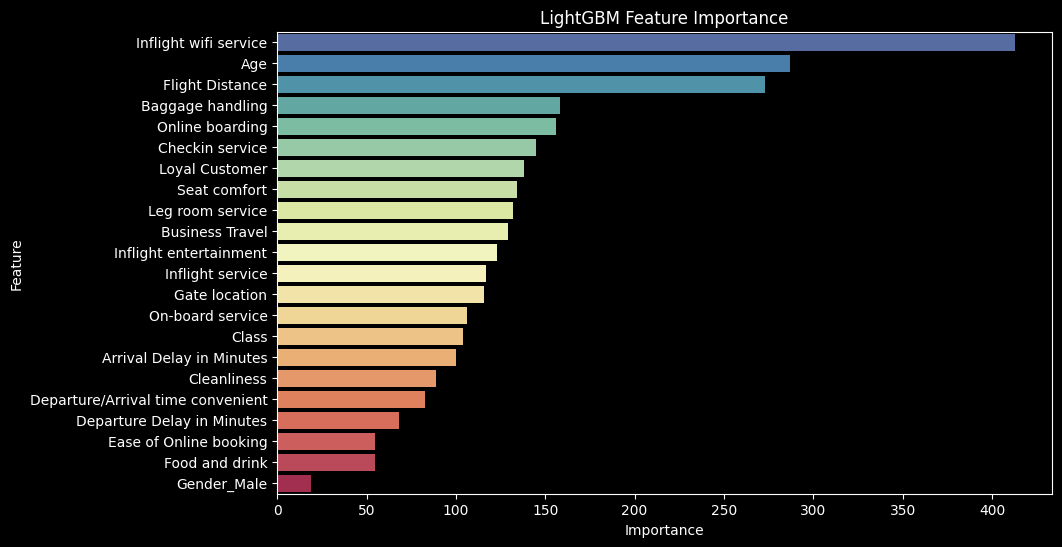

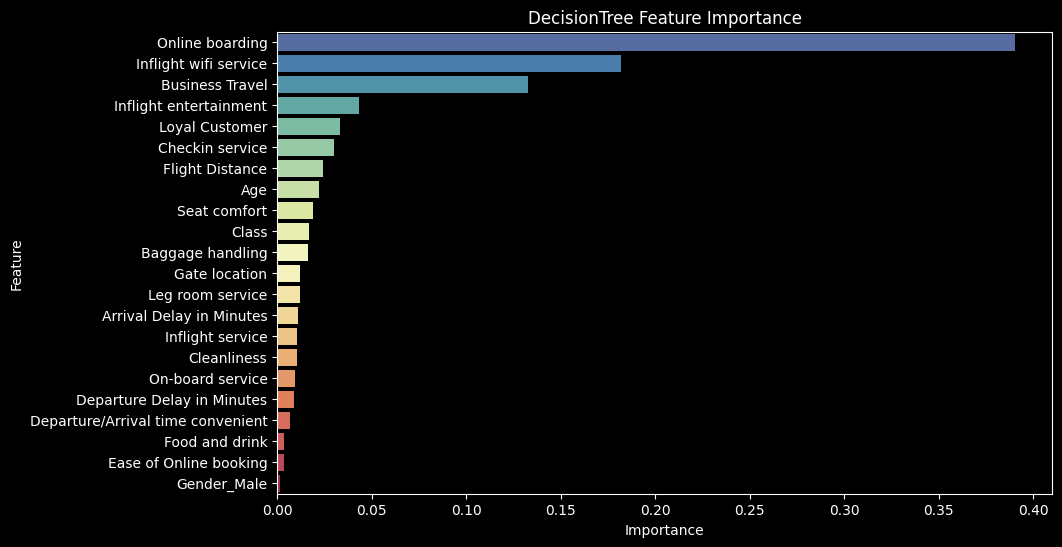

In [12]:
# Train LGBMClassifier
trained_lgb_model = train_model(lgb_model, X_train_balanced, y_train_balanced)

# Get and plot feature importance of LGBMClassifier
lgbm_feature_importance = get_feature_importance(trained_lgb_model)
plot_feature_importance(lgbm_feature_importance, title='LightGBM Feature Importance')

# Train DecisionTreeClassifier
trained_dec_tree = train_model(dec_tree, X_train_balanced, y_train_balanced)

# Get and plot feature importance of DecisionTreeClassifier
dec_tree_feature_importance = get_feature_importance(trained_dec_tree)
plot_feature_importance(dec_tree_feature_importance, title='DecisionTree Feature Importance')

### **Top 10 Common Features in LightGBM and DecisionTree Classifiers**

1. Online boarding
2. Inflight wifi service
3. Business Travel
4. Inflight entertainment
5. Loyal Customer
6. Checkin service
7. Age
8. Flight Distance
9. Seat comfort
10. Class